# üçá Projet Deep Learning   
## D√©tection automatis√©e des maladies de la vigne

Ce notebook utilise le [Grapevine Disease Dataset](https://www.kaggle.com/datasets/rm1000/grape-disease-dataset-original), contenant **9027 images de feuilles de vigne** r√©parties en quatre classes¬†:  
- **Black Rot**  
- **ESCA**  
- **Leaf Blight**  
- **Healthy**

L‚Äôobjectif est de concevoir un mod√®le de **classification d'images** reposant sur des r√©seaux de neurones convolutifs (**CNN**) pour identifier visuellement les maladies affectant les plants de vigne.

Ce projet illustre une application concr√®te du **deep learning** dans le domaine de l‚Äôagriculture de pr√©cision. Une telle approche permettrait une **d√©tection rapide et fiable** des pathologies, contribuant ainsi √† une meilleure gestion des cultures viticoles.

---
üë®‚Äçüíª **Technologies cl√©s :**  
- Python  
- TensorFlow  
- CNN & Transfer Learning + Fine tuning 
- Visualisation et √©valuation des performances du mod√®le

In [1]:
#  Suppression des logs et warnings TensorFlow
import os, logging, warnings

# Ne conserver que les erreurs critiques (FATAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Optionnel : masquer les warnings Python (deprecation, clipping, etc.)
warnings.filterwarnings('ignore')


In [ ]:
#  Imports et configuration
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers

# Active le GPU si dispo
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Impossible d'activer la croissance m√©moire GPU :", e)

# Chemins du dataset
train_dir = './Grapevine Disease Dataset Original Data/train'
test_dir  = './Grapevine Disease Dataset Original Data/test'

# Param√®tres
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20


In [3]:
# Verification des doublons d'images

import os
import hashlib
import numpy as np
from PIL import Image

#  Chargement des datasets depuis vos r√©pertoires
train_dir = './Grapevine Disease Dataset Original Data/train'
test_dir  = './Grapevine Disease Dataset Original Data/test'

def get_all_image_paths(directory):
    """
Recherche les doublons d'images dans un dossier donn.
Parcourt r√©cursivement tous les fichiers images dans le dossier sp√©cifi√©,
calcule le hash md5 bas√© sur le contenu des pixels de chaque image, 
et d√©tecte les fichiers identiques (doublons.
Args:
    directory (str): Chemin du dossier √† analyse.
Returns:
    list of tuple: Liste de paires de chemins de fichiers consid√©r√©s comme doublons.
    """
    image_paths = []
    for root, _, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(root, f))
    return image_paths

def hash_image(image_path):
    """
    Calcule le hash md5 d'une image bas√© sur son contenu de pixels.
    Args:
        image_path (str): Chemin de l'image √† hasher.
    Returns:
        str: Hash md5 de l'image.
    """
    img = Image.open(image_path).convert('RGB')
    arr = np.array(img)
    arr_bytes = arr.tobytes()
    return hashlib.md5(arr_bytes).hexdigest()

def build_hash_dict(image_paths):
    """
    G√©n√®re un dictionnaire {hash: [chemins]} pour toutes les images.
    Args:
        image_paths (list of str): Liste des chemins d'images.
    Returns:
        dict: Dictionnaire des hash md5 vers une liste de fichiers ayant ce hash.
    """
    hash_dict = {}
    for path in image_paths:
        try:
            h = hash_image(path)
            if h in hash_dict:
                hash_dict[h].append(path)
            else:
                hash_dict[h] = [path]
        except Exception as e:
            print(f"Erreur avec {path}: {e}")
    return hash_dict

# 1. Lister toutes les images
train_images = get_all_image_paths(train_dir)
test_images = get_all_image_paths(test_dir)

# 2. G√©n√©rer les hash pour chaque set
train_hashes = build_hash_dict(train_images)
test_hashes  = build_hash_dict(test_images)

# 3. Chercher les doublons dans chaque set (interne)
def extract_duplicates(hash_dict):
    """
    Extrait toutes les paires de fichiers images identiques (doublons internes).

    Args:
        hash_dict (dict): Dictionnaire {hash: [liste de chemins de fichiers]}.

    Returns:
        list of tuple: Liste des paires de fichiers consid√©r√©s comme doublons.
    """
    return [(v[0], v[1]) for v in hash_dict.values() if len(v) > 1]

train_dupes = extract_duplicates(train_hashes)
test_dupes  = extract_duplicates(test_hashes)

# 4. Doublons entre train et test (cross-set)
cross_dupes = []
for h in train_hashes:
    if h in test_hashes:
        # Toutes les combinaisons train vs test pour ce hash
        for p1 in train_hashes[h]:
            for p2 in test_hashes[h]:
                cross_dupes.append((p1, p2))

# 5. Affichage des r√©sultats
print(f"Nombre de doublons dans le train : {len(train_dupes)}")
for d1, d2 in train_dupes:
    print(f"[Train] Doublon trouv√© : {d1} <--> {d2}")

print(f"\nNombre de doublons dans le test : {len(test_dupes)}")
for d1, d2 in test_dupes:
    print(f"[Test] Doublon trouv√© : {d1} <--> {d2}")

print(f"\nNombre de doublons entre train et test : {len(cross_dupes)}")
for d1, d2 in cross_dupes:
    print(f"[Cross-set] Doublon trouv√© : {d1} <--> {d2}")

# 6. Bloc suppression automatique (optionnel) - A UTILISER AVEC PR√âCAUTION !!
def delete_duplicates(dupe_pairs):
    for f1, f2 in dupe_pairs:
        # On supprime le 2e fichier (mais tu peux changer la logique)
        try:
            os.remove(f2)
            print(f"Supprim√© : {f2}")
        except Exception as e:
            print(f"Erreur suppression {f2} : {e}")

# Pour supprimer les doublons, d√©commenter une des lignes ci-dessous :
# delete_duplicates(train_dupes)
# delete_duplicates(test_dupes)
# delete_duplicates(cross_dupes)


Nombre de doublons dans le train : 0

Nombre de doublons dans le test : 0

Nombre de doublons entre train et test : 0


In [ ]:

#  Data Augmentation adapt√©e
# Ajout : rotation ¬±20¬∞, zoom l√©ger,

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,            # Rotations ¬±20¬∞
    zoom_range=0.1,               # Zoom l√©ger
    width_shift_range=0.05,       # D√©calage horizontal
    height_shift_range=0.05,      # D√©calage vertical
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

#  G√©n√©ration des datasets multi-classes (softmax 4)
# Assume que les 4 classes sont dans des sous-dossiers
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes :", class_names)


Found 5779 images belonging to 4 classes.
Found 1443 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.
Classes : ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']


In [ ]:

#  Mod√®le CNN from scratch (4 classes, softmax)
def create_multiclass_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = create_multiclass_cnn()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 224, 224, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 224, 224, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 224, 224, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 224, 224, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 112, 112, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 112, 112, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 26,014,116 (99.24 MB)

 Trainable params: 26,012,452 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [7]:
import time

# Cell 5 : Callbacks et entra√Ænement
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    callbacks.ModelCheckpoint('../Models/DL_best_cnn_multiclass.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

start = time.time()

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=cb,
    verbose=1
)
end = time.time()
elapsed = end - start
hours = int(elapsed // 3600)
minutes = int((elapsed % 3600) // 60)
seconds = int(elapsed % 60)
print(f"Dur√©e d'entra√Ænement : {hours}h {minutes}min {seconds}s")

Epoch 1/20
181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 823ms/step - accuracy: 0.7139 - loss: 0.8310
Epoch 1: val_accuracy improved from -inf to 0.26195, saving model to ../Models/DL_best_cnn_multiclass.keras
181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 160s 873ms/step - accuracy: 0.7143 - loss: 0.8298 - val_accuracy: 0.2620 - val_loss: 3.3308 - learning_rate: 0.0010
Epoch 2/20
181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 868ms/step - accuracy: 0.8741 - loss: 0.3298
Epoch 2: val_accuracy improved from 0.26195 to 0.50243, saving model to ../Models/DL_best_cnn_multiclass.keras
181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 168s 927ms/step - accuracy: 0.8741 - loss: 0.3296 - val_accuracy: 0.5024 - val_loss: 1.6885 - learning_rate: 0.0010
Epoch 3/20
181/181 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 873ms/step - accuracy: 0.9232 - loss: 0.2025
Epoch 3: val_accuracy impro

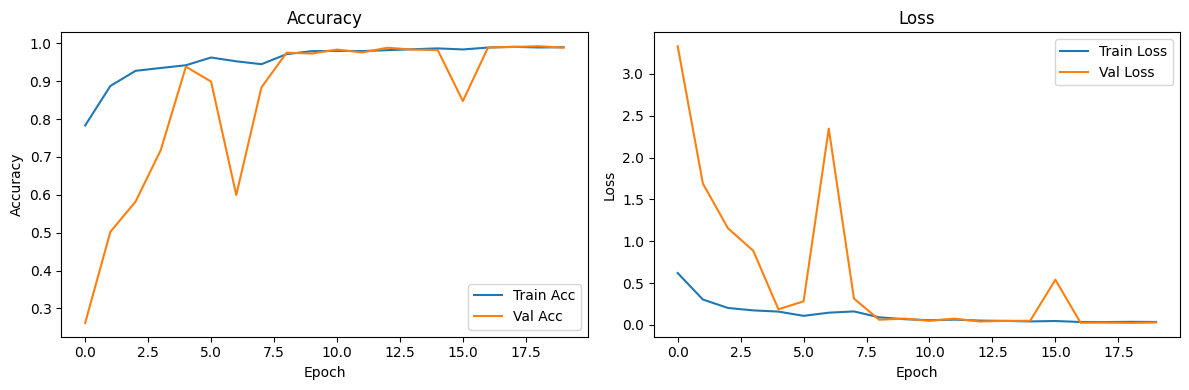

In [ ]:

#  Visualisation courbes entra√Ænement
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  √âvaluation sur le test set
results = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
for name, val in zip(model.metrics_names, results):
    print(f"{name.capitalize():12}: {val:.4f}")


57/57 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 113ms/step - accuracy: 0.8027 - loss: 0.6070
Loss        : 0.2676
Compile_metrics: 0.9125


57/57 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 114ms/step

Classification report:
               precision    recall  f1-score   support

   Black Rot       1.00      0.67      0.80       472
        ESCA       0.79      1.00      0.88       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       0.94      1.00      0.97       430

    accuracy                           0.91      1805
   macro avg       0.93      0.92      0.91      1805
weighted avg       0.93      0.91      0.91      1805

Loss globale test (categorical_crossentropy) : 0.2676


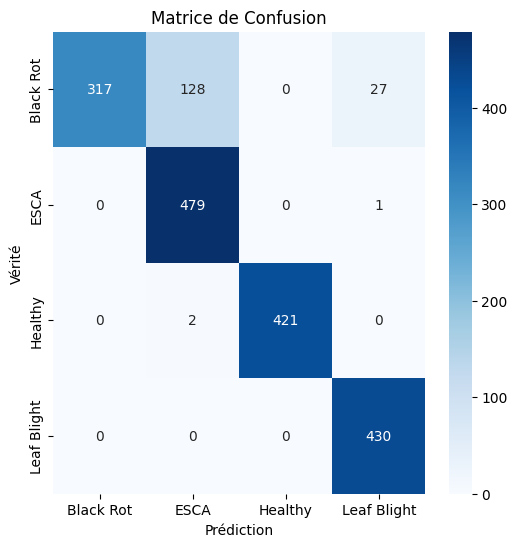

In [14]:
# Cell 8 : Matrice de confusion et rapport classification
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns

test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

# Calcul de la loss globale sur le test set
# y_true doit √™tre one-hot, or test_gen.classes donne des entiers. On convertit :
import tensorflow as tf

y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
loss_fn = CategoricalCrossentropy()
test_loss = loss_fn(y_true_onehot, y_prob).numpy()
print(f"Loss globale test (categorical_crossentropy) : {test_loss:.4f}")

# Graphique de la matrice de confusion

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©diction")
plt.ylabel("V√©rit√©")
plt.show()


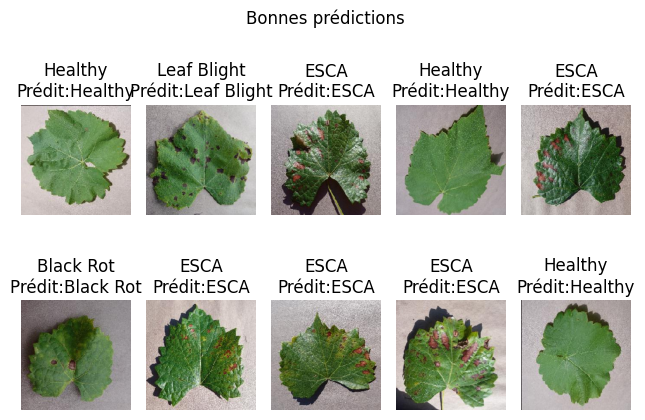

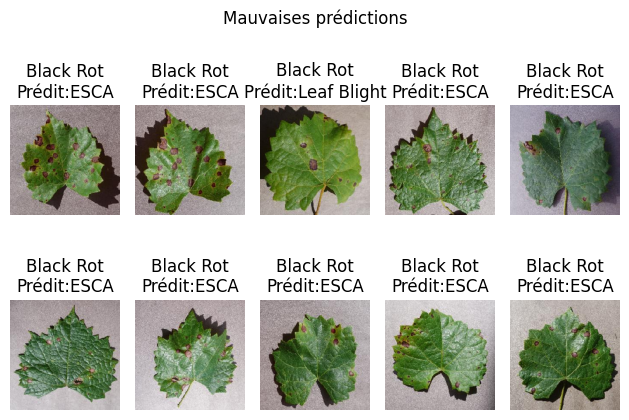

In [ ]:
#  Visualisation pr√©dictions correctes/incorrectes
import random

def plot_predictions(gen, y_true, y_pred, class_names, correct=True, n=10):
    idxs = np.where(y_true == y_pred)[0] if correct else np.where(y_true != y_pred)[0]
    if len(idxs) == 0:
        print("Aucune image √† afficher.")
        return
    n_display = min(n, len(idxs))
    sample = np.random.choice(idxs, n_display, replace=False)
    gen.reset()
    Xs, Ys = [], []
    for _ in range(len(gen)):
        xb, yb = next(gen)
        Xs.append(xb)
        Ys.append(yb)
    X_all = np.vstack(Xs)
    for i, idx in enumerate(sample):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_all[idx])
        plt.title(f"{class_names[y_true[idx]]}\nPr√©dit:{class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle("Bonnes pr√©dictions" if correct else "Mauvaises pr√©dictions")
    plt.tight_layout()
    plt.show()

plot_predictions(test_gen, y_true, y_pred, class_names, correct=True, n=10)
plot_predictions(test_gen, y_true, y_pred, class_names, correct=False, n=10)


## Analyse des r√©sultats & pistes d'am√©lioration

### Analyse globale

- Le CNN entra√Æn√© from scratch obtient de **tr√®s bonnes performances**¬†:  
  - **Accuracy test¬†: ~91%**
  - **Loss globale test¬†: ~0.27**
- Certaines classes (Healthy, Leaf Blight) sont tr√®s bien reconnues (pr√©cision et rappel proches de 1).
- Quelques confusions persistent, en particulier entre **Black Rot** et **ESCA**, visibles dans la matrice de confusion et les f1-scores.
- Les exemples de bonnes et mauvaises pr√©dictions montrent que le mod√®le apprend la majorit√© des cas, mais reste perfectible sur certaines vari√©t√©s de feuilles ou de sympt√¥mes.

### Limites du mod√®le

- **Temps d'entra√Ænement √©lev√©¬†:** Environ 1h pour converger √† de bonnes performances.
- **N√©cessite beaucoup d'epochs et de puissance de calcul** pour bien apprendre toutes les classes.
- **Risque d'overfitting** si le nombre d'images par classe ou la diversit√© n'est pas suffisante.

### Pistes d'am√©lioration

- **Transfer Learning¬†:**  
  Utiliser un mod√®le pr√©-entra√Æn√© (ResNet, EfficientNet, etc.) comme extracteur de features, puis entra√Æner uniquement la derni√®re couche dense.  
  Cela permet de gagner √©norm√©ment de temps, et d‚Äôobtenir de tr√®s bonnes performances d√®s les premi√®res epochs, surtout avec peu de donn√©es.
- **Fine-Tuning¬†:**  
  Apr√®s un premier entra√Ænement rapide (toutes les couches gel√©es sauf la derni√®re), on peut ‚Äúd√©geler‚Äù les derni√®res couches du backbone et les r√©entra√Æner avec un taux d‚Äôapprentissage plus bas, pour am√©liorer encore la pr√©cision et l‚Äôadaptation au dataset.
- **Augmentation de donn√©es plus avanc√©e¬†:**  
  Enrichir la data augmentation (blur, contrast, brightness, flipping, crop, etc.) pour eviter l'overfiting.
- **Collecte de donn√©es¬†:**  
  Ajouter des images plus vari√©es (diff√©rentes lumi√®res, angles, stades de maladies) pour am√©liorer la g√©n√©ralisation.
- **Analyse d‚Äôerreurs**¬†:  
  √âtudier les cas de confusion dans la matrice de confusion pour ajuster le mod√®le ou le dataset.

---

**Conclusion¬†:**  
Le CNN from scratch prouve l‚Äôefficacit√© de l‚Äôapprentissage profond sur ce type de donn√©es, mais la comparaison avec le transfer learning et le fine-tuning mettra en √©vidence l‚Äôint√©r√™t de ces m√©thodes pour l‚Äôindustrialisation et la rapidit√© de mise en ≈ìuvre.
